# Gesture Recognition
We are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [4]:
# Import the libraries
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import skimage
from skimage.transform import resize
import datetime
import cv2
import abc
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Set seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [6]:
BASE_PATH = '/home/datasets/Project_data'

### Overview

We will implement a hybrid architecture combining a Convolutional Neural Network (CNN) with a Recurrent Neural Network (RNN). In this approach, the Conv2D network extracts feature vectors from images, which are then fed into an RNN-based network as a sequence. The RNN processes these sequential features, and its output is passed through a conventional softmax layer for classification.

To streamline model development, we will define a BuildModel class as an abstract foundation for constructing models and data generators tailored for gesture recognition in smart TVs. This class will manage essential configurations, including file paths, image properties, and hyperparameters. Additionally, it will provide functionalities for generating training data batches, training the model, and an abstract method for defining the model architecture.

## Generator

In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
class BuildModel(metaclass=abc.ABCMeta):

    def initialize_path(self, BASE_PATH):

        self.train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
        self.train_path = '/home/datasets/Project_data/train'
        self.val_path = '/home/datasets/Project_data/val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_props(self, image_height=100, image_width=100):

        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):

        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    def generator(self, source_path, folder_list, augment=False):

        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_samples = len(t) % batch_size

            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):

        seq_length = remaining_samples if remaining_samples else batch_size

        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_length, self.num_classes))

        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))


        for folder in range(seq_length):
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))


                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])


        return(batch_data, batch_labels)


    def train_model(self, model, augment_data=False):

        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def model_definition(self):
        pass


### Visualization of Training and Validation Metrics

This can be accomplished using the `plot` function, which visualizes the training and validation loss, along with `categorical accuracy` and `validation categorical accuracy`. It utilizes the training metrics stored in the history object returned by `model.fit()`. The generated plot consists of two subplots, each illustrating the progression of a specific metric over epochs.

In [13]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

### Model 1 - CNN with LSTM

In [52]:
class RNNCNN1(BuildModel):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
rnn_cnn_1 = RNNCNN1()
rnn_cnn_1.initialize_path(BASE_PATH)
rnn_cnn_1.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_1.initialize_hyperparameters(number_of_sample_frames=30, batch_size=20, num_epochs=20)
rnn_cnn_model_1 = rnn_cnn_1.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 30, 60, 60, 32)  

In [54]:
print("Total Parameters: ", rnn_cnn_model_1.count_params())
model_1 = rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4389 - categorical_accuracy: 0.3710
Epoch 00001: saving model to model_init_2025-04-0106_30_08.818038/model-00001-1.43888-0.37104-1.64132-0.22000.keras
34/34 [==============================] - 191s 6s/step - loss: 1.4389 - categorical_accuracy: 0.3710 - val_loss: 1.6413 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1905 - categorical_accuracy: 0.5136
Epoch 00002: saving model to model_init_2025-04-0106_30_08.818038/model-00002-1.19054-0.51357-1.88725-0.20000.keras
34/34 [==============================] - 177s 5s/step - loss: 1.1905 - categorical_accuracy: 0.5136 - val_loss: 1.8873 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0397 - categorical_accuracy: 0.5754
Epoch 00003: saving model to model_init_2025-04-0106_30_08.818038/model-00003-1.03970-0.5

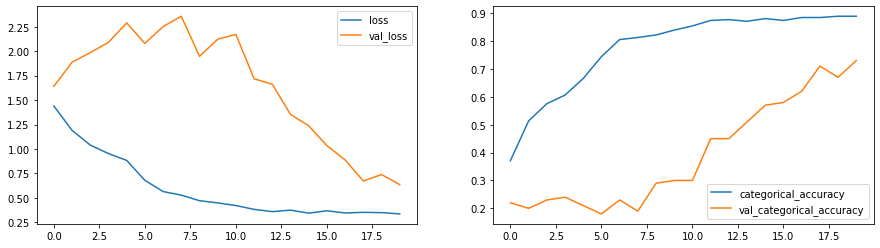

In [55]:
plot(model_1)

***Observations:***

Using the base CNN with LSTM architecture, we trained on all 30 frames extracted from the video. The model achieved a training accuracy of 88% and a validation accuracy of 73%, suggesting potential overfitting. To mitigate this, we plan to modify the model by reducing the number of frames, batch size, and epochs.

### Model 2 - CNN with LSTM (with reduced hyperparameters)

In [56]:
rnn_cnn_2 = RNNCNN1()
rnn_cnn_2.initialize_path(BASE_PATH)
rnn_cnn_2.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_2.initialize_hyperparameters(number_of_sample_frames=20, batch_size=10, num_epochs=10)
rnn_cnn_model_2 = rnn_cnn_2.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 20, 60, 60, 32)  

In [57]:
print("Total Parameters: ", rnn_cnn_model_2.count_params())
model_2 = rnn_cnn_2.train_model(rnn_cnn_model_2, augment_data=True)

Total Parameters:  1657445
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4233 - categorical_accuracy: 0.3665
Epoch 00001: saving model to model_init_2025-04-0107_29_32.308583/model-00001-1.42327-0.36652-1.68061-0.16000.keras
67/67 [==============================] - 120s 2s/step - loss: 1.4233 - categorical_accuracy: 0.3665 - val_loss: 1.6806 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2631 - categorical_accuracy: 0.4600
Epoch 00002: saving model to model_init_2025-04-0107_29_32.308583/model-00002-1.26311-0.46003-2.44905-0.14000.keras
67/67 [==============================] - 118s 2s/step - loss: 1.2631 - categorical_accuracy: 0.4600 - val_loss: 2.4491 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1600 - categorical_accuracy: 0.5181
Epoch 00003: saving model to model_init_2025-04-0107_29_32.308583/model-00003-1.15999-0.5

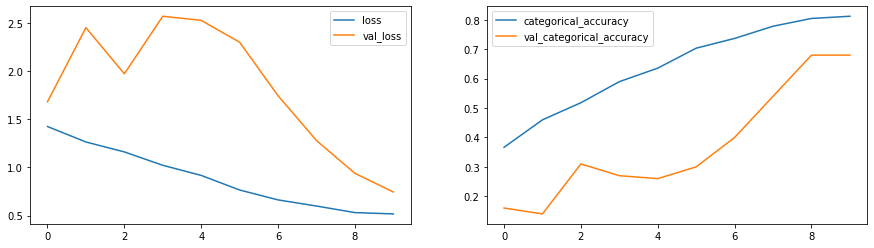

In [58]:
plot(model_2)

***Observations:***

Reducing the number of hyperparameters led to a drop in training accuracy to 81% and validation accuracy to 68%, indicating underfitting. To mitigate this, we will focus on reducing the number of frames while maintaining a batch size of 20 and training for 20 epochs.

### Model 3 - CNN with LSTM (with reduced frames)

In [59]:
rnn_cnn_3 = RNNCNN1()
rnn_cnn_3.initialize_path(BASE_PATH)
rnn_cnn_3.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_3.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_3 = rnn_cnn_3.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_116 (TimeD  (None, 18, 60, 60, 32)  

In [60]:
print("Total Parameters: ", rnn_cnn_model_3.count_params())
model_3 = rnn_cnn_3.train_model(rnn_cnn_model_3, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3693 - categorical_accuracy: 0.3793
Epoch 00001: saving model to model_init_2025-04-0107_49_26.584721/model-00001-1.36934-0.37934-1.80737-0.21000.keras
34/34 [==============================] - 122s 4s/step - loss: 1.3693 - categorical_accuracy: 0.3793 - val_loss: 1.8074 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1357 - categorical_accuracy: 0.5181
Epoch 00002: saving model to model_init_2025-04-0107_49_26.584721/model-00002-1.13568-0.51810-1.72913-0.24000.keras
34/34 [==============================] - 118s 4s/step - loss: 1.1357 - categorical_accuracy: 0.5181 - val_loss: 1.7291 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9868 - categorical_accuracy: 0.6101
Epoch 00003: saving model to model_init_2025-04-0107_49_26.584721/model-00003-0.98675-0.6

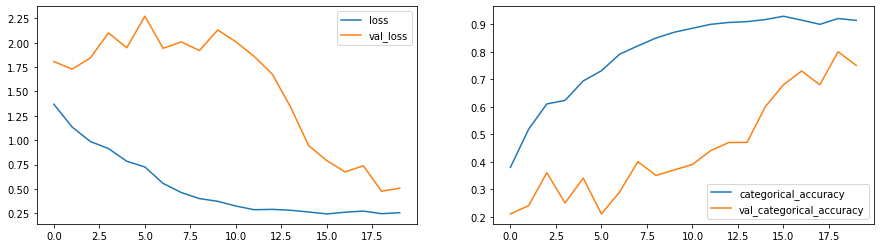

In [61]:
plot(model_3)

***Observations:***

The **training accuracy continues to improve, reaching 91%**, while the **validation accuracy peaks at 75%**, still suggesting potential overfitting. To combat this, we plan to **explore an alternative architecture by integrating CNN with GRU**, keeping the same number of frames, to enhance generalization and performance.

### Model 4 - CNN with GRU

In [65]:
class RNNCNN2(BuildModel):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
rnn_cnn_4 = RNNCNN2()
rnn_cnn_4.initialize_path(BASE_PATH)
rnn_cnn_4.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_4.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_4 = rnn_cnn_4.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_141 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_142 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_143 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_144 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_145 (TimeD  (None, 18, 60, 60, 32)  

In [67]:
print("Total Parameters: ", rnn_cnn_model_4.count_params())
model_4 = rnn_cnn_4.train_model(rnn_cnn_model_4, augment_data=True)

Total Parameters:  2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5002 - categorical_accuracy: 0.3590
Epoch 00001: saving model to model_init_2025-04-0108_36_28.247678/model-00001-1.50021-0.35897-1.84452-0.27000.keras
34/34 [==============================] - 111s 3s/step - loss: 1.5002 - categorical_accuracy: 0.3590 - val_loss: 1.8445 - val_categorical_accuracy: 0.2700 - lr: 0.0020
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1623 - categorical_accuracy: 0.5173
Epoch 00002: saving model to model_init_2025-04-0108_36_28.247678/model-00002-1.16232-0.51735-2.00053-0.27000.keras
34/34 [==============================] - 111s 3s/step - loss: 1.1623 - categorical_accuracy: 0.5173 - val_loss: 2.0005 - val_categorical_accuracy: 0.2700 - lr: 0.0020
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0463 - categorical_accuracy: 0.5656
Epoch 00003: saving model to model_init_2025-04-0108_36_28.247678/model-00003-1.04627-0.5

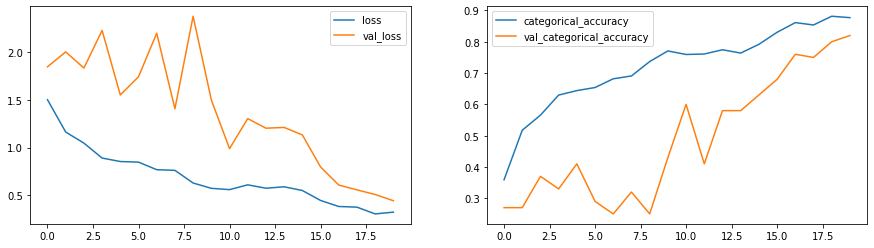

In [68]:
plot(model_4)

***Observations:***

Integrating **GRU-RNN** led to a **slight drop in training accuracy to 87%**, while **validation accuracy declined to 82%**, signaling overfitting. To address this, we plan to **introduce additional augmentation techniques, such as rotation**, and reattempt the same architecture to improve generalization and mitigate overfitting.

### Enhance `BuildModel` class to incorporate additional augmentation techniques such as `Rotation`

In [8]:
class BuildModelWithRotation(metaclass=abc.ABCMeta):

    def initialize_path(self, BASE_PATH):

        self.train_doc = np.random.permutation(open(BASE_PATH + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(BASE_PATH + '/' + 'val.csv').readlines())
        self.train_path = BASE_PATH + '/' + 'train'
        self.val_path = BASE_PATH + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_props(self, image_height=100, image_width=100):

        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):

        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    def generator(self, source_path, folder_list, augment=False):

        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_samples = len(t) % batch_size

            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):

        seq_length = remaining_samples if remaining_samples else batch_size

        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_length, self.num_classes))

        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))


        for folder in range(seq_length):
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))


                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    matrix2d = cv2.getRotationMatrix2D((self.image_width//2, self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, matrix2d, (self.image_width, self.image_height))

                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])


        return(batch_data, batch_labels)


    def train_model(self, model, augment_data=False):

        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def model_definition(self):

        pass


### Model 5 - CNN with LSTM (with modified Augmentation Technique)

In [70]:
class RNNCNN3(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [71]:
rnn_cnn_5 = RNNCNN3()
rnn_cnn_5.initialize_path(BASE_PATH)
rnn_cnn_5.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_5.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_5 = rnn_cnn_5.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_154 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_155 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_156 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_157 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_158 (TimeD  (None, 18, 60, 60, 32) 

In [72]:
print("Total Parameters: ", rnn_cnn_model_5.count_params())
model_5 = rnn_cnn_5.train_model(rnn_cnn_model_5, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3969 - categorical_accuracy: 0.4005
Epoch 00001: saving model to model_init_2025-04-0109_13_51.626567/model-00001-1.39690-0.40045-1.82620-0.17000.keras
34/34 [==============================] - 111s 3s/step - loss: 1.3969 - categorical_accuracy: 0.4005 - val_loss: 1.8262 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1066 - categorical_accuracy: 0.5422
Epoch 00002: saving model to model_init_2025-04-0109_13_51.626567/model-00002-1.10658-0.54223-1.94958-0.17000.keras
34/34 [==============================] - 110s 3s/step - loss: 1.1066 - categorical_accuracy: 0.5422 - val_loss: 1.9496 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0432 - categorical_accuracy: 0.5649
Epoch 00003: saving model to model_init_2025-04-0109_13_51.626567/model-00003-1.04319-0.5

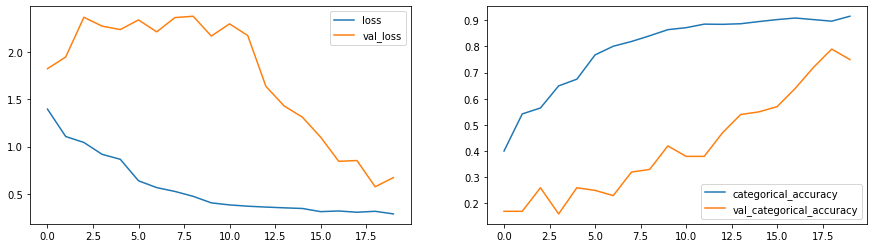

In [73]:
plot(model_5)

***Observations:***

After incorporating **rotation in the augmentation phase**, the **training accuracy slightly dropped to 91%**, while the **validation accuracy improved to 77%**, suggesting better generalization. Next, we will explore **transfer learning** to determine if it can further boost validation accuracy and enhance model performance.

### Model 6 - CNN with LSTM (with Transfer Learning)

In [9]:
class RNNCNN_TL_LSTM(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
rnn_cnn_6 = RNNCNN_TL_LSTM()
rnn_cnn_6.initialize_path(BASE_PATH)
rnn_cnn_6.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_6.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_6 = rnn_cnn_6.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_6.summary()

2025-04-01 10:18:09.415192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-01 10:18:09.447686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-01 10:18:09.450809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-01 10:18:09.457078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-01 10:18:09.460199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [11]:
print("Total Parameters: ", rnn_cnn_model_6.count_params())
model_6 = rnn_cnn_6.train_model(rnn_cnn_model_6, augment_data=True)

Total Parameters:  3840453
Epoch 1/20


2025-04-01 10:18:14.601705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


  1/133 [..............................] - ETA: 10:34 - loss: 1.8243 - categorical_accuracy: 0.1000

2025-04-01 10:18:16.309952: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


133/133 [==============================] - ETA: 0s - loss: 1.3707 - categorical_accuracy: 0.4133
Epoch 00001: saving model to model_init_2025-04-0110_18_11.134462/model-00001-1.37075-0.41327-0.98046-0.62000.keras
133/133 [==============================] - 101s 728ms/step - loss: 1.3707 - categorical_accuracy: 0.4133 - val_loss: 0.9805 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8537 - categorical_accuracy: 0.6757
Epoch 00002: saving model to model_init_2025-04-0110_18_11.134462/model-00002-0.85372-0.67572-0.69413-0.73000.keras
133/133 [==============================] - 101s 766ms/step - loss: 0.8537 - categorical_accuracy: 0.6757 - val_loss: 0.6941 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6856 - categorical_accuracy: 0.7360
Epoch 00003: saving model to model_init_2025-04-0110_18_11.134462/model-00003-0.68562-0.73605-0.74521-0.76000.k

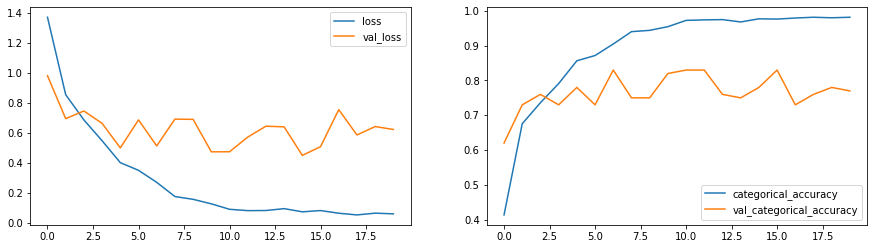

In [14]:
plot(model_6)

***Observations:***

Implementing LSTM with transfer learning boosted the **training accuracy to 98%**, yet the **validation accuracy remained at 77%**, indicating potential overfitting. This may stem from the **MobileNet weights not being trained**, limiting the model’s ability to generalize. Next, we will explore whether **training MobileNet’s weights alongside LSTM** can address this issue and improve overall performance.

### Model 7 - CNN with LSTM (with trainable weights of Transfer Learning)

In [15]:
class RNNCNN_TL_LSTM_2(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))

        # Training weights
        for layer in model.layers:
            layer.trainable = True


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn_7 = RNNCNN_TL_LSTM_2()
rnn_cnn_7.initialize_path(BASE_PATH)
rnn_cnn_7.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_7.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_7 = rnn_cnn_7.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [17]:
print("Total Parameters: ", rnn_cnn_model_7.count_params())
model_7 = rnn_cnn_7.train_model(rnn_cnn_model_7, augment_data=True)

Total Parameters:  3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3320 - categorical_accuracy: 0.4397
Epoch 00001: saving model to model_init_2025-04-0110_51_41.257324/model-00001-1.33205-0.43967-0.81566-0.66000.keras
133/133 [==============================] - 99s 726ms/step - loss: 1.3320 - categorical_accuracy: 0.4397 - val_loss: 0.8157 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9384 - categorical_accuracy: 0.6312
Epoch 00002: saving model to model_init_2025-04-0110_51_41.257324/model-00002-0.93843-0.63122-1.10568-0.57000.keras
133/133 [==============================] - 95s 716ms/step - loss: 0.9384 - categorical_accuracy: 0.6312 - val_loss: 1.1057 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6930 - categorical_accuracy: 0.7579
Epoch 00003: saving model to model_init_2025-04-0110_51_41.257324/model-000

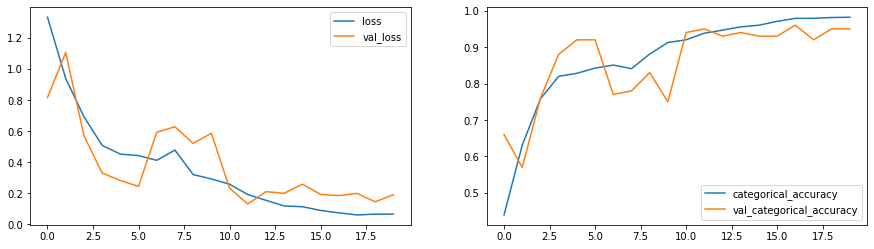

In [18]:
plot(model_7)

***Observations:***

After training the MobileNet weights, the **training accuracy surged to 98%**, with **validation accuracy reaching 95%**. However, this gain came at the expense of significantly longer training time due to a **fourfold increase in parameters** within the LSTM architecture. Moving forward, we will investigate whether **reducing the parameter count with GRU** while still leveraging MobileNet’s trainable weights can further enhance accuracy and efficiency.

### Model 8 - CNN with GRU  (with trainable weights of Transfer Learning)

In [ ]:
class RNNCNN_TL_GRU(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_8 = RNNCNN_TL_GRU()
rnn_cnn_8.initialize_path(BASE_PATH)
rnn_cnn_8.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_8.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_8 = rnn_cnn_8.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)              

In [ ]:
print("Total Parameters: ", rnn_cnn_model_8.count_params())
model_8 = rnn_cnn_8.train_model(rnn_cnn_model_8, augment_data=True)

Total Parameters:  3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3138 - categorical_accuracy: 0.4683
Epoch 00001: saving model to model_init_2025-04-0111_23_46.397063/model-00001-1.31385-0.46833-0.78893-0.66000.keras
133/133 [==============================] - 100s 738ms/step - loss: 1.3138 - categorical_accuracy: 0.4683 - val_loss: 0.7889 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8272 - categorical_accuracy: 0.6787
Epoch 00002: saving model to model_init_2025-04-0111_23_46.397063/model-00002-0.82725-0.67873-0.41369-0.88000.keras
133/133 [==============================] - 94s 711ms/step - loss: 0.8272 - categorical_accuracy: 0.6787 - val_loss: 0.4137 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5125 - categorical_accuracy: 0.8084
Epoch 00003: saving model to model_init_2025-04-0111_23_46.397063/model-00

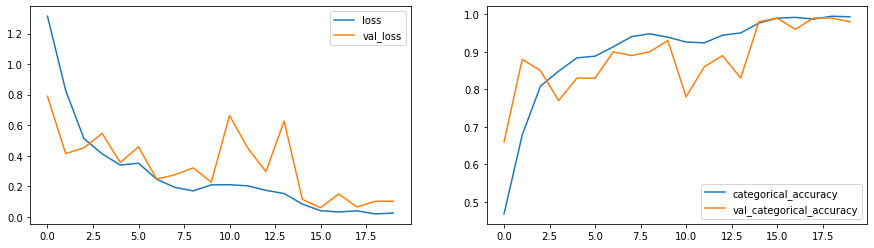

In [ ]:
plot(model_8)

***Observations:***

By leveraging GRU and transfer learning with pre-trained weights, our model achieves an impressive 99% training accuracy and 98% validation accuracy. This marks a significant breakthrough, effectively addressing overfitting while ensuring robust generalization. Given its strong performance, we confidently finalize this model for evaluation.

### Final Analysis

### Model Evaluation

In [36]:
from keras.models import load_model
model = load_model('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/model_init_2025-04-0111_23_46.397063/model-00020-0.02392-0.99321-0.10166-0.98000.keras')

In [37]:
test_generator = RNNCNN_TL_GRU()
test_generator.initialize_path(BASE_PATH)
test_generator.initialize_image_props(image_height=120, image_width=120)
test_generator.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)
batch_data, batch_labels = next(g)

In [38]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])